# Feature Extraction and HMM Creation

#### *Bayesian ML: Katy Koo, Kevin Sianto, Samuel Martinez Koss, Veera Anand*

\

Repository:

https://github.com/koobcbc/Bayesian_heart_rate_prediction

\

References:

https://echonet.github.io/dynamic/index.html

https://github.com/echonet/dynamic?tab=readme-ov-file

https://www.nature.com/articles/s41586-020-2145-8

## Setup

In [ ]:
!pip install hmmlearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 12.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from PIL import Image
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
pd.options.display.float_format = '{:,.4f}'.format

In [ ]:
base_dir = '.../dynamic'

## Loading

For more information on how these pickled data are obtained, see **1. Data Sampling and Frame Extraction.ipynb**.

In [ ]:
pickle_path = os.path.join(base_dir, 'a4c-video-dir/extracted_frames.pkl')
df_videos = pd.read_pickle(pickle_path)
print(df_videos.head)
print(df_videos.shape)

<bound method NDFrame.head of              Video_Name                                             Frames
0    0X1012703CDC1436FE  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
1    0X1059077339EF0869  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
2    0X1227CDDF6A114129  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
3    0X14BFDFE46468D601  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
4    0X166087A5E749713A  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
..                  ...                                                ...
203   0XD82A46274BA199D  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
204    0XE763608A3EFEF2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
205   0XE96D228DFDC48DC  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
206   0XF145A7B0E6F417E  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
207   0XFB550573BDD938A  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...

[208 rows x 2 columns]>
(208, 2)


In [ ]:
print(df_videos['Frames'][0])

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 2 2]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 1 1]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 1 2]
  [0 0 0 ... 1 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 1]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 1]
  [0 0 0 ... 2 3 0]
  [0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 2 0]
  [0 0 0 ... 1 0 0]
  [0 0 0 ... 0 0 3]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 1 0 0]
  [0 0 0 ... 0 0 2]]]


In [ ]:
print(df_videos['Frames'][0].shape)

(201, 112, 112)


## Transfer Learning Setup and Feature Extraction

Since the goal of our project is to predict the Ejection Fraction (EF), we need to get that information from the FileList csv and add that to the main dataframe.

In [ ]:
filelist_path = os.path.join(base_dir, 'a4c-video-dir/FileList.csv')
echo_files = pd.read_csv(filelist_path)
echo_files.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.4984,14.8814,69.2105,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.1020,40.3839,98.7429,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.3638,14.2678,37.9097,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.5451,33.1431,72.9142,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.8877,127.5819,169.8550,112,112,52,207,VAL


In [ ]:
df_videos_v2 = df_videos.copy()
df_videos_v2 = pd.merge(df_videos_v2, echo_files, left_on='Video_Name', right_on = 'FileName', how='left')
df_videos_v2.head()

,Video_Name,Frames,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X1012703CDC1436FE,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0X1012703CDC1436FE,41.0144,71.3791,121.0112,112,112,50,201,TEST
1,0X1059077339EF0869,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0X1059077339EF0869,66.1994,21.1534,62.5828,112,112,50,201,TRAIN
2,0X1227CDDF6A114129,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0X1227CDDF6A114129,76.1430,17.0392,71.4222,112,112,50,201,TRAIN
3,0X14BFDFE46468D601,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0X14BFDFE46468D601,45.4099,54.6171,100.0495,112,112,50,201,TRAIN
4,0X166087A5E749713A,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0X166087A5E749713A,34.6505,31.6181,48.3831,112,112,50,201,TRAIN


Creating a train test split for model testing:

In [ ]:
df_videos_v2 = df_videos_v2[["Video_Name", "Frames", "EF"]]
df_videos_train, df_videos_test = train_test_split(df_videos_v2, test_size=0.2, random_state=42)
df_videos_train = df_videos_train.reset_index(drop=True)
df_videos_test = df_videos_test.reset_index(drop=True)

In [ ]:
print(df_videos_train.shape)
print(df_videos_test.shape)

(166, 3)
(42, 3)


Creating a Frame Feature Extractor class here to extract the relevant frames using transfer learning from ResNet18. We chose ResNet18 as our pre-trained model to use because of a few reasons:

1.   Pre-trained on millions of diverse images, where the general features should transfer well to medical domains
2.   Lightweight compared to other pre-trained models, balancing between computational efficiency and performance

This class is created so that we can have flexibility in the format of the frames (Grayscale or RGB) and which layer we want to extract from ResNet18.

The main function's output will be a feature list extracted from the pre-trained model for each frame given to it, with the shape num_videos * num_frames * feature_layer_dimensions



In [ ]:
class FrameFeatureExtractor:
    """Class to extract features from video frames using ResNet18"""

    def __init__(self, feature_layer='avgpool'):
        """Initialize the feature extractor with a pretrained ResNet18"""
        # Load pretrained ResNet18
        self.model = models.resnet18(pretrained=True)

        # Set the model to evaluation mode
        self.model.eval()

        # Define the feature extraction layer
        self.feature_layer = feature_layer
        self.features = None

        # Register hook to get features
        self._register_hook()

        # Move model to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)

    def _register_hook(self):
        """Register a hook to extract features from a specific layer"""
        def hook(module, input, output):
            # For average pooling layer, flatten the output
            if isinstance(output, torch.Tensor):
                if len(output.shape) == 4:  # Feature maps
                    self.features = output.detach().flatten(1)
                else:  # Already flattened
                    self.features = output.detach()
            else:
                # For some models, output might be a tuple
                self.features = output[0].detach().flatten(1)

        # Get the layer
        if self.feature_layer == 'avgpool':
            layer = self.model.avgpool
        elif self.feature_layer == 'layer4':
            layer = self.model.layer4
        else:
            raise ValueError(f"Unknown feature layer: {self.feature_layer}")

        # Register the hook
        layer.register_forward_hook(hook)

    def extract_features_from_frames(self, frames):
        """
        Extract features from a batch of frames

        Args:
            frames: Numpy array of shape (n_frames, height, width) or (n_frames, height, width, channels)

        Returns:
            features: Numpy array of shape (n_frames, feature_dim)
        """
        # Convert frames to torch tensor
        if frames.ndim == 3:  # Grayscale frames
            # Add channel dimension
            frames_tensor = torch.from_numpy(frames).unsqueeze(1).float()
            frames_tensor = frames_tensor.repeat(1, 3, 1, 1)  # Repeat grayscale across 3 channels
        else:  # RGB frames
            # Move channel dimension to correct position (frames, channels, height, width)
            frames_tensor = torch.from_numpy(frames).permute(0, 3, 1, 2).float()

        # Normalize
        frames_tensor = frames_tensor / 255.0

        # Apply ImageNet normalization if RGB
        if frames_tensor.shape[1] == 3:
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(self.device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(self.device)
            frames_tensor = frames_tensor.to(self.device)
            frames_tensor = (frames_tensor - mean) / std

        # Process in batches to avoid memory issues
        batch_size = 32
        features_list = []

        with torch.no_grad():
            for i in range(0, len(frames_tensor), batch_size):
                batch = frames_tensor[i:i+batch_size].to(self.device)

                # Resize to match ResNet input size if needed
                if batch.shape[2] != 224 or batch.shape[3] != 224:
                    batch = F.interpolate(batch, size=(224, 224), mode='bilinear', align_corners=False)

                # Forward pass
                _ = self.model(batch)

                # Get features from hook
                features_list.append(self.features.cpu().numpy())

        # Concatenate all batches
        return np.vstack(features_list)

The process_dataframe_videos function is created to extract the relevant features while maintaining the EF numbers in the format needed for modeling

In [ ]:
def process_dataframe_videos(df_videos, ef_column='EF'):
    """
    Process the DataFrame with video frames for GMM-HMM training

    Args:
        df_videos: DataFrame with video frames and EF labels
        ef_column: Column name for ejection fraction labels

    Returns:
        features_list: List of feature sequences for each video
        lengths: List of sequence lengths
        ef_labels: List of EF labels
    """
    # Initialize feature extractor
    feature_extractor = FrameFeatureExtractor()

    features_list = []
    lengths = []
    ef_labels = []

    # Process each video in the DataFrame
    for idx, row in df_videos.iterrows():
        frames = row['Frames']  # Shape (201, 112, 112) or (201, 112, 112, 3)

        # Extract features from frames
        features = feature_extractor.extract_features_from_frames(frames)

        features_list.append(features)
        lengths.append(len(features))

        # Store EF label if available
        if ef_column in df_videos.columns:
            ef_labels.append(row[ef_column])

    return features_list, lengths, ef_labels

In [ ]:
features_list, lengths, _ = process_dataframe_videos(df_videos_train)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 227MB/s]


In [ ]:
features_list[0].shape

(201, 512)

## Modeling with Gaussian HMM

In this function, we train a Gaussian HMM on the video frames extracted to model the hidden states for each frame per video. The hidden states are then turned into state distributions to be fed into a regression model that we choose to predict the EF. Metrics will be provided in the output of this function to evaluate the model.

In [ ]:
def train_gmm_hmm_from_dataframe(df_videos, n_states=5, ef_column='EF', test_size=0.2, regression_model = 'linear'):
    """
    Train a Gaussian model using the DataFrame with video frames, and then pushing it to a regression model to predict the EF.

    Args:
        df_videos: DataFrame with video frames and EF labels
        n_states: Number of hidden states in HMM
        ef_column: Column name for ejection fraction labels
        test_size: Fraction of data to use for testing

    Returns:
        hmm_model: Trained Gaussian-HMM model
        ef_regressor: Trained regressor for EF prediction
        train_states: State distributions for train set. Extracted to see the results of the Gaussian HMM
        X_train: Features for train set
    """
    # Extract features from videos
    print("Extracting features from videos...")
    features_list, lengths, ef_labels = process_dataframe_videos(df_videos, ef_column)

    # Check if we have EF labels
    if not ef_labels:
        raise ValueError(f"No EF labels found in column '{ef_column}'")

    # Split into train and test sets
    indices = np.arange(len(features_list))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)

    # Create train and test sets
    train_features = [features_list[i] for i in train_indices]
    train_lengths = [lengths[i] for i in train_indices]
    train_ef = [ef_labels[i] for i in train_indices]

    test_features = [features_list[i] for i in test_indices]
    test_lengths = [lengths[i] for i in test_indices]
    test_ef = [ef_labels[i] for i in test_indices]

    # Concatenate features for HMM training
    X_train = np.vstack(train_features)

    # Train GMM-HMM
    print(f"Training Gaussian-HMM with {n_states} states...")
    hmm_model = hmm.GaussianHMM(n_components=n_states,
                         covariance_type='diag', n_iter=1000,
                         init_params='mc', params='mc')

    hmm_model.fit(X_train, lengths=train_lengths)

    # Extract state distributions for EF regression
    train_states = []
    start = 0
    for length in train_lengths:
        end = start + length
        seq = hmm_model.predict(X_train[start:end])
        # Get state distribution
        state_dist = np.bincount(seq, minlength=n_states) / len(seq)
        train_states.append(state_dist)
        start = end

    if regression_model == 'linear':
      # Train linear regressor for EF prediction
      from sklearn.linear_model import LinearRegression
      ef_regressor = LinearRegression()
      ef_regressor.fit(np.array(train_states), train_ef)

    elif regression_model == 'ridge':
      # Train ridge regression for EF prediction
      from sklearn.linear_model import Ridge
      ef_regressor = Ridge(alpha=1.0)
      ef_regressor.fit(np.array(train_states), train_ef)

    elif regression_model == 'random_forest':
      # Train Random Forest Regressor for EF prediction
      ef_regressor = RandomForestRegressor(n_estimators=100)
      ef_regressor.fit(np.array(train_states), train_ef)

    elif regression_model == 'gradient_boosting':
      from sklearn.ensemble import GradientBoostingRegressor
      ef_regressor = GradientBoostingRegressor(n_estimators=100)
      ef_regressor.fit(np.array(train_states), train_ef)

    elif regression_model == 'xgboost':
      import xgboost as xgb
      ef_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
      ef_regressor.fit(np.array(train_states), train_ef)

    else:
      raise ValueError(f"Unknown regression model: {regression_model}")

    # Evaluate on test set
    test_predictions = []
    X_test = np.vstack(test_features)

    # Extract state distributions for test data
    test_states = []
    start = 0
    for length in test_lengths:
        end = start + length
        seq = hmm_model.predict(X_test[start:end])
        state_dist = np.bincount(seq, minlength=n_states) / len(seq)
        test_states.append(state_dist)
        test_predictions.append(ef_regressor.predict([state_dist])[0])
        start = end

    # Calculate test metrics
    test_mse = mean_squared_error(test_ef, test_predictions)
    test_mae = mean_absolute_error(test_ef, test_predictions)
    test_mape = mean_absolute_percentage_error(test_ef, test_predictions)

    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test MAPE: {test_mae:.1f}%")

    # Plot predicted vs actual EF
    plt.figure(figsize=(10, 6))
    plt.scatter(test_ef, test_predictions, alpha=0.7)
    plt.plot([min(test_ef), max(test_ef)], [min(test_ef), max(test_ef)], 'r--')
    plt.xlabel('Actual EF (%)')
    plt.ylabel('Predicted EF (%)')
    plt.title('Predicted vs Actual Ejection Fraction')
    plt.grid(True)
    plt.show()

    return hmm_model, ef_regressor, train_states, X_train

Extracting features from videos...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Gaussian-HMM with 4 states...
Test MSE: 155.7257
Test MAE: 10.0559
Test MAPE: 10.1%


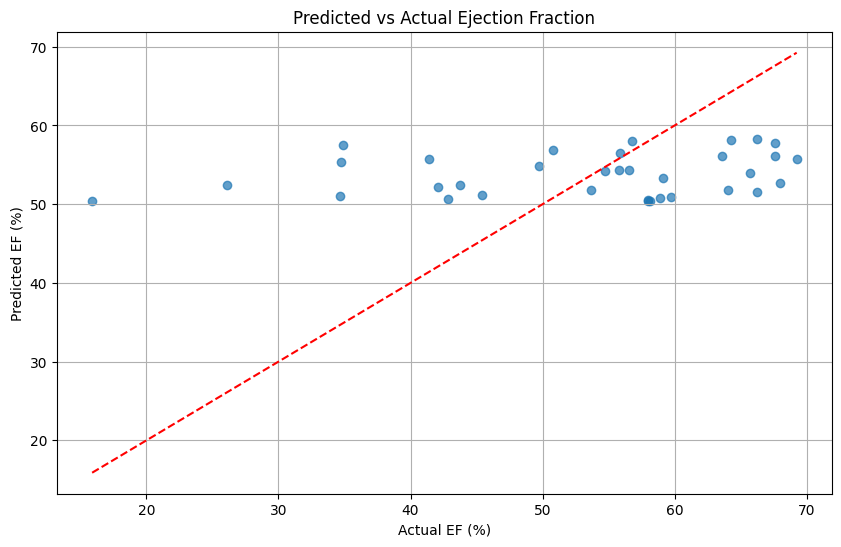

In [ ]:
hmm_model, ef_regressor, train_states, X_train = train_gmm_hmm_from_dataframe(
        df_videos_train, n_states=4, regression_model='linear')

Extracting features from videos...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Gaussian-HMM with 4 states...
Test MSE: 193.3863
Test MAE: 11.1278
Test MAPE: 11.1%


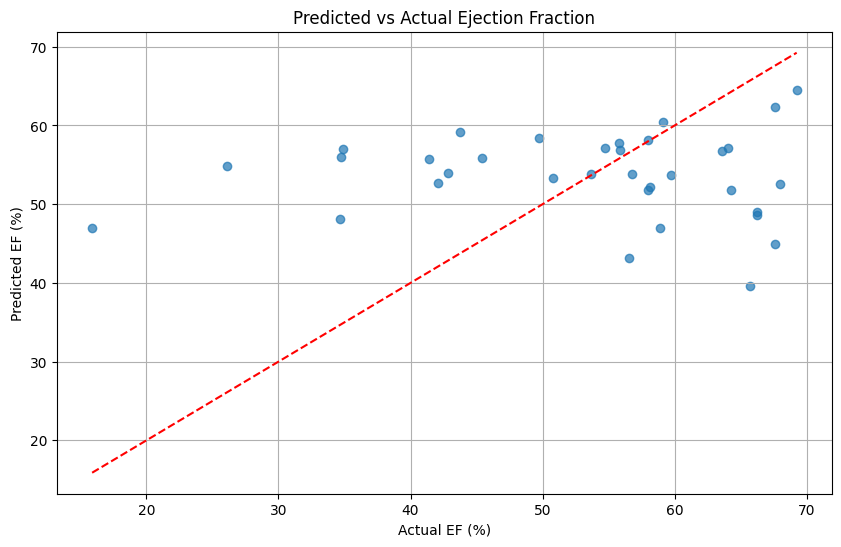

In [ ]:
hmm_model, ef_regressor, train_states, X_train = train_gmm_hmm_from_dataframe(
        df_videos_train, n_states=4, regression_model='random_forest')

Extracting features from videos...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Gaussian-HMM with 4 states...
Test MSE: 198.1339
Test MAE: 10.8696
Test MAPE: 10.9%


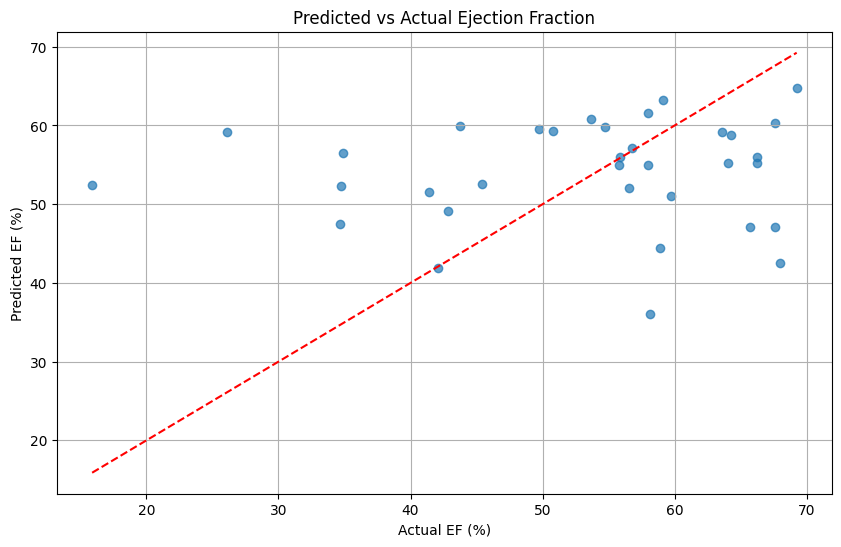

In [ ]:
hmm_model, ef_regressor, train_states, X_train = train_gmm_hmm_from_dataframe(
        df_videos_train, n_states=4, regression_model='gradient_boosting')

Extracting features from videos...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Gaussian-HMM with 4 states...
Test MSE: 247.1692
Test MAE: 12.8478
Test MAPE: 12.8%


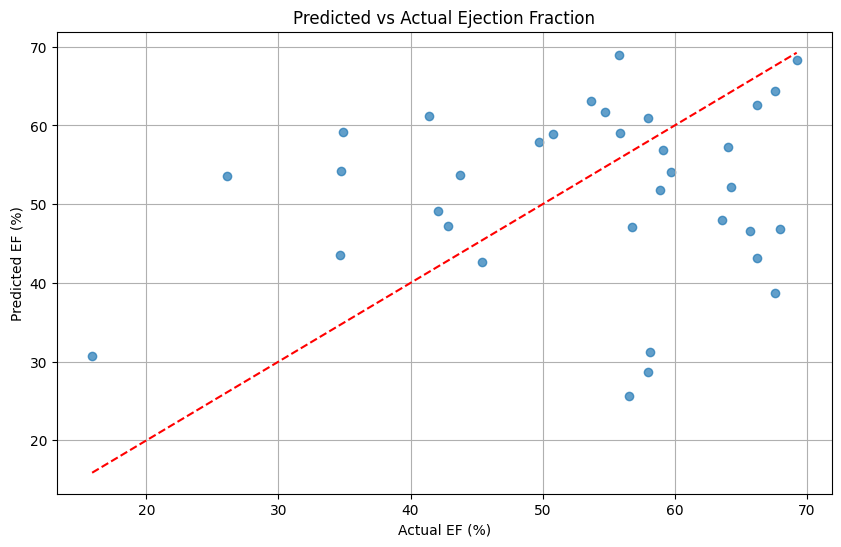

In [ ]:
hmm_model, ef_regressor, train_states, X_train = train_gmm_hmm_from_dataframe(
        df_videos_train, n_states=4, regression_model='xgboost')

In [ ]:
train_states

[array([0.95024876, 0.        , 0.04477612, 0.00497512]),
 array([0.05970149, 0.16915423, 0.        , 0.77114428]),
 array([0., 0., 1., 0.]),
 array([0., 0., 0., 1.]),
 array([0.02985075, 0.        , 0.04975124, 0.92039801]),
 array([0.05472637, 0.        , 0.90547264, 0.039801  ]),
 array([0.03482587, 0.92537313, 0.        , 0.039801  ]),
 array([0.01492537, 0.        , 0.960199  , 0.02487562]),
 array([0.26865672, 0.        , 0.38308458, 0.34825871]),
 array([0.70149254, 0.        , 0.26865672, 0.02985075]),
 array([0.82587065, 0.00995025, 0.12437811, 0.039801  ]),
 array([0.10945274, 0.        , 0.        , 0.89054726]),
 array([1., 0., 0., 0.]),
 array([0.51741294, 0.        , 0.        , 0.48258706]),
 array([0.00497512, 0.        , 0.85572139, 0.13930348]),
 array([0.35323383, 0.48258706, 0.        , 0.1641791 ]),
 array([0.01492537, 0.        , 0.19402985, 0.79104478]),
 array([0.07960199, 0.00497512, 0.82587065, 0.08955224]),
 array([0.        , 0.        , 0.45771144, 0.542288

In [ ]:
def predict_ef(hmm_model, ef_regressor, video_frames, n_states):
    """
    Predict EF for a new video

    Args:
        hmm_model: Trained GMM-HMM model
        ef_regressor: Trained regressor for EF prediction
        video_frames: Numpy array of frames from a video
        n_states: Number of states in HMM

    Returns:
        ef_pred: Predicted EF percentage
    """
    # Initialize feature extractor
    feature_extractor = FrameFeatureExtractor()

    # Extract features
    features = feature_extractor.extract_features_from_frames(video_frames)

    # Get state sequence
    state_seq = hmm_model.predict(features)

    # Get state distribution
    state_dist = np.bincount(state_seq, minlength=n_states) / len(state_seq)

    # Predict EF
    ef_pred = ef_regressor.predict(state_dist.reshape(1, -1))[0]

    return ef_pred

In [ ]:
ef_pred_list = []
for i in range(df_videos_test.shape[0]):
    ef_pred = predict_ef(hmm_model, ef_regressor, df_videos_test['Frames'][i], 4)
    ef_pred_list.append(ef_pred)
df_videos_test_final = df_videos_test.copy()
df_videos_test_final['EF_Pred'] = ef_pred_list

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are depreca

In [ ]:
df_videos_test_final = df_videos_test_final.drop(columns=['Frames'])

In [ ]:
df_videos_test_final.head(20)

,Video_Name,EF,EF_Pred
0,0X6C8FB4DE38C55D2D,63.5015,59.1579
1,0X1BF00F2E669B915E,24.9713,47.5052
2,0X386E38E6214B10A1,55.8946,55.8671
3,0X437D0633EFFC953B,56.1285,42.2195
4,0X6F6EA16F5E3467AA,65.5388,62.9207
5,0X19DF9461CA5F498F,69.6763,54.5612
6,0X45F50AF374B2D1E6,55.7632,63.9204
7,0X5D2F7405A43DB64D,65.2555,60.9834
8,0X1C9F9EC57DDAFE0B,60.1525,56.8994
9,0X65C0691EFC9931F6,48.0001,49.5802


In [ ]:
rmse_test = root_mean_squared_error(df_videos_test_final['EF'], df_videos_test_final['EF_Pred'])
mae_test = mean_absolute_error(df_videos_test_final['EF'], df_videos_test_final['EF_Pred'])
mape_test = mean_absolute_percentage_error(df_videos_test_final['EF'], df_videos_test_final['EF_Pred'])*100

In [ ]:
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MAPE: {mape_test:.2f}%")

Test RMSE: 10.8823
Test MAE: 8.2974
Test MAPE: 17.58%
